In [20]:
import pandas as pd
from math import pi
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

[Link to dataset](https://archive.ics.uci.edu/dataset/186/wine+quality)

In [2]:
dfr = pd.read_csv('./dataset/winequality-red.csv', sep=';')
target = 'quality'

### Out Dataset:

In [3]:
dfr.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Our Features:

In [4]:
list(dfr.columns)

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

### Each feature range:

In [5]:
for feature in dfr.columns:
    print(f'{feature} - [{min(dfr[feature])}, {max(dfr[feature])}]')

fixed acidity - [4.6, 15.9]
volatile acidity - [0.12, 1.58]
citric acid - [0.0, 1.0]
residual sugar - [0.9, 15.5]
chlorides - [0.012, 0.611]
free sulfur dioxide - [1.0, 72.0]
total sulfur dioxide - [6.0, 289.0]
density - [0.99007, 1.00369]
pH - [2.74, 4.01]
sulphates - [0.33, 2.0]
alcohol - [8.4, 14.9]
quality - [3, 8]


### Lets check for missing values:

In [6]:
dfr.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

#### No missing values!

---

# Dataset Features Explanation

### 1. **Fixed Acidity**
- **Definition**: The non-volatile acids that do not evaporate during fermentation, primarily tartaric acid, which contributes to the tartness of wine.
- **Impact on Wine**: Affects the wine's flavor and preservation. High fixed acidity can make the wine taste sour or sharp, while low fixed acidity might result in a flat taste.
- **Range**: 4.6–15.9 g/L

### 2. **Volatile Acidity**
- **Definition**: Acids that can evaporate, such as acetic acid (the main component of vinegar).
- **Impact on Wine**: High volatile acidity can cause an unpleasant vinegar-like taste, while low levels are essential for a balanced flavor.
- **Range**: 0.12–1.58 g/L

### 3. **Citric Acid**
- **Definition**: A minor acid in wine, often added to enhance freshness and increase acidity.
- **Impact on Wine**: Provides a slight citrusy flavor and enhances the perception of freshness, particularly in white wines.
- **Range**: 0.0–1.0 g/L

### 4. **Residual Sugar**
- **Definition**: The amount of sugar left in wine after fermentation.
- **Impact on Wine**: Determines the sweetness level. Low residual sugar results in a dry wine, while higher levels contribute to sweeter wines.
- **Range**: 0.9–15.5 g/L

### 5. **Chlorides**
- **Definition**: The concentration of chloride ions, which may come from natural sources or winemaking processes.
- **Impact on Wine**: Contributes to the saltiness or minerality of the wine, which can enhance complexity when balanced.
- **Range**: 0.011–0.611 g/L

### 6. **Free Sulfur Dioxide**
- **Definition**: The portion of sulfur dioxide (SO₂) in wine that is not bound to other molecules and is available to act as an antimicrobial and antioxidant agent.
- **Impact on Wine**: Protects wine from oxidation and spoilage, but excessive levels can lead to unpleasant aromas.
- **Typical Range**: 1.0–72.0 mg/L

### 7. **Total Sulfur Dioxide**
- **Definition**: The total amount of sulfur dioxide, both free and bound, present in the wine.
- **Impact on Wine**: Important for preservation, but too much can impair taste and cause health concerns for sensitive individuals.
- **Typical Range**: 6.0 - 289.0 mg/L (regulated by wine type and laws)

### 8. **Density**
- **Definition**: The mass per unit volume of the wine, influenced by sugar and alcohol content.
- **Impact on Wine**: Used to estimate alcohol and residual sugar levels. Higher density often indicates higher sweetness.
- **Typical Range**: 0.99007–1.00369 g/mL

### 9. **pH**
- **Definition**: Measures the acidity level, indicating how acidic or basic the wine is.
- **Impact on Wine**: Affects stability, taste, and color. Lower pH (more acidic) preserves freshness, while higher pH can lead to spoilage if not managed.
- **Range**: 2.74–4.01

### 10. **Sulphates**
- **Definition**: Compounds related to sulfur, often added to wine for preservation.
- **Impact on Wine**: Acts as an antimicrobial and antioxidant, contributing to stability and longevity. Excess levels can impart a bitter or astringent taste.
- **Range**: 0.33–2.0 g/L

### 11. **Alcohol**
- **Definition**: Ethanol content produced during fermentation.
- **Impact on Wine**: Affects body, flavor, and aroma. Higher alcohol content enhances the perception of warmth and boldness.
- **Typical Range**: 8.4–14.9%

### 12. **Quality - Target Feature**
- **Definition**: A subjective score often based on sensory evaluations (e.g., taste, aroma, balance) and sometimes correlated with chemical properties.
- **Impact on Wine**: Serves as an overall indicator of the wine's acceptability and desirability to consumers and critics.
- **Typical Range**: 3–8

---

These traits collectively determine the wine's chemical balance, flavor profile, and market appeal. Winemakers and analysts monitor and adjust these parameters to produce wine of desired quality and style.


---
### Let's start by examining the distibution of the target feature which is "quality":

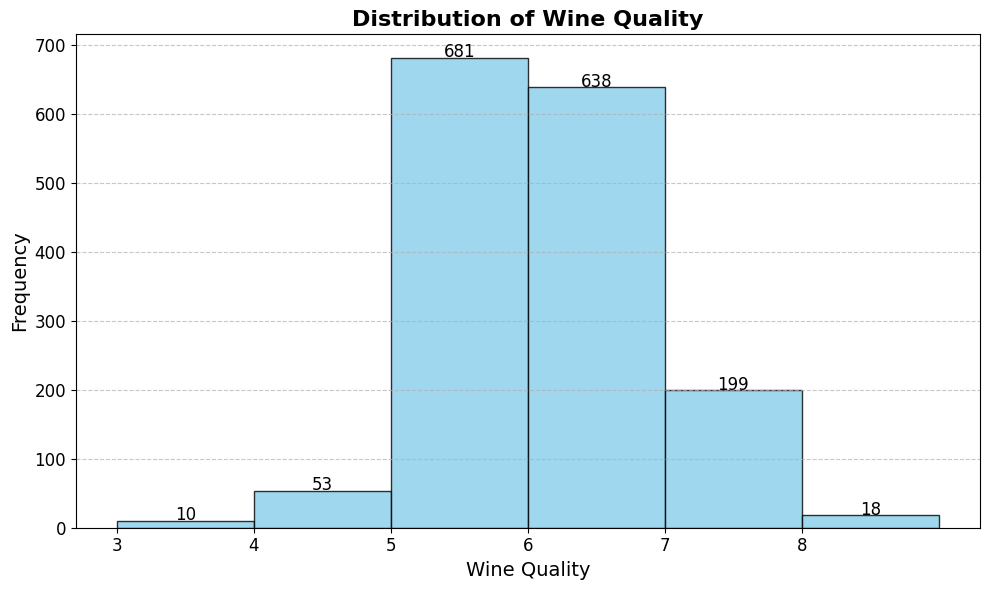

In [7]:
plt.figure(figsize=(10, 6))
counts, bins, bars = plt.hist(
    dfr['quality'], 
    bins=range(dfr['quality'].min(), dfr['quality'].max() + 2), 
    edgecolor='black', 
    color='skyblue', 
    alpha=0.8
)

plt.title("Distribution of Wine Quality", fontsize=16, weight='bold')
plt.xlabel("Wine Quality", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(range(dfr['quality'].min(), dfr['quality'].max() + 1), fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 1, 
             int(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()


### As we can see most of our data has a quality in between 5-6.
This might cause as some porblems later to predict some very fine wines or some pretty bad ones - since most of the wines present in our data is average.


---
### Also, our target feature is skewed. We will later have to use skeness tactics to combat this problam.

---
### It make sense now then, to check for some specific features that have high correlations with the target feature,
We can start by using a correlations heat map of all the features with the target:

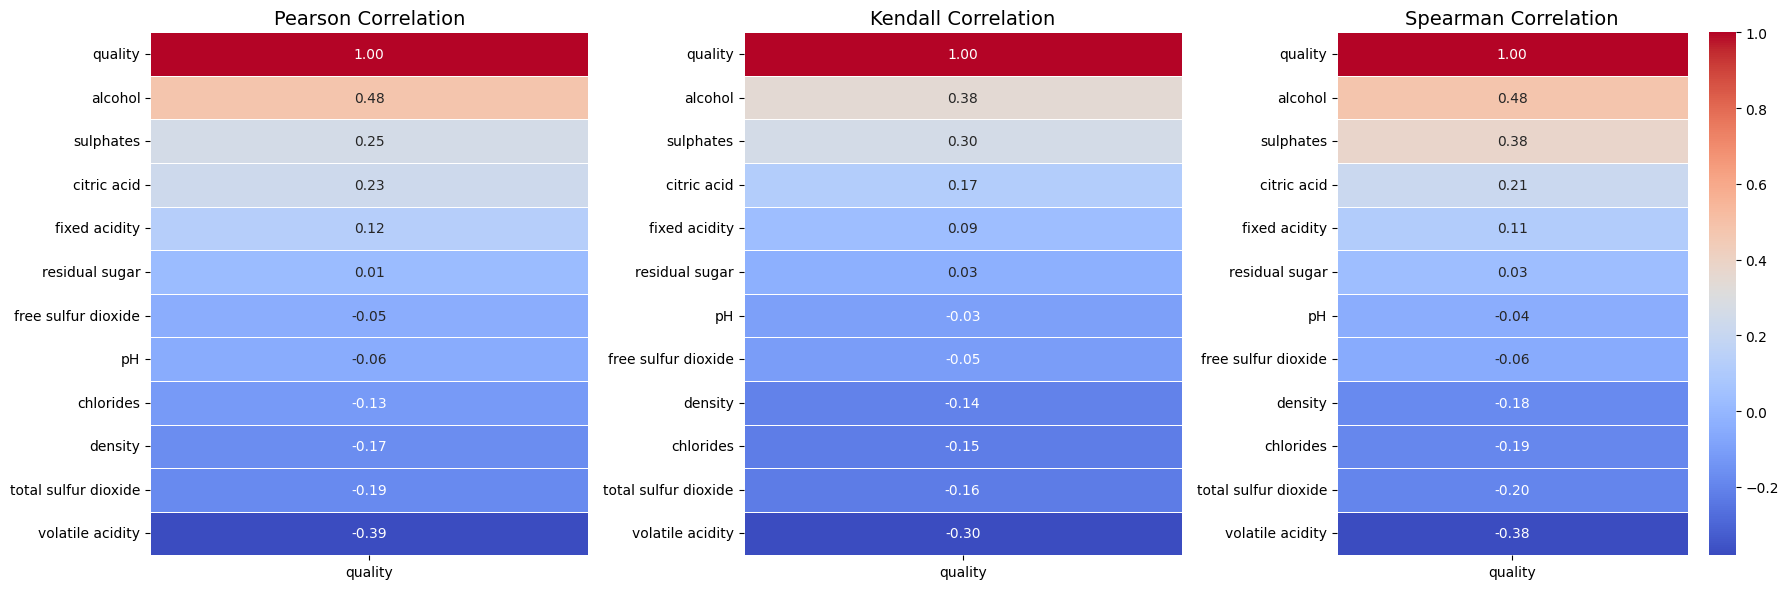

In [8]:
correlation_methods = {
    'Pearson': dfr.corr(method='pearson')[[target]].sort_values(by=target, ascending=False),
    'Kendall': dfr.corr(method='kendall')[[target]].sort_values(by=target, ascending=False),
    'Spearman': dfr.corr(method='spearman')[[target]].sort_values(by=target, ascending=False)
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (method, corr) in enumerate(correlation_methods.items()):
    sns.heatmap(
        corr,
        annot=True,
        cmap='coolwarm',
        cbar=True if i == 2 else False,
        fmt=".2f",
        linewidths=0.5,
        annot_kws={"fontsize": 10},
        ax=axes[i]
    )
    axes[i].set_title(f"{method} Correlation", fontsize=14)
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()


We checked Pearson, Kendall, and Spearman correlations. We can clearly see the alcohol has some positive effect on the quality of the wine, similarly, sulphates and citric acid both have a weak but still some kind of positive effect as well. On the other hand, volatile acidity has a negative effect on the quality of the wine.

But checking for correlation is not enough, sometimes as intelligent people we might spot correlation that might be unique to this dataset, lets plot each feature with our target feature, and check wether the previous features we found actually have some kind of correlation, and if our correlation tests might have missed some other features.

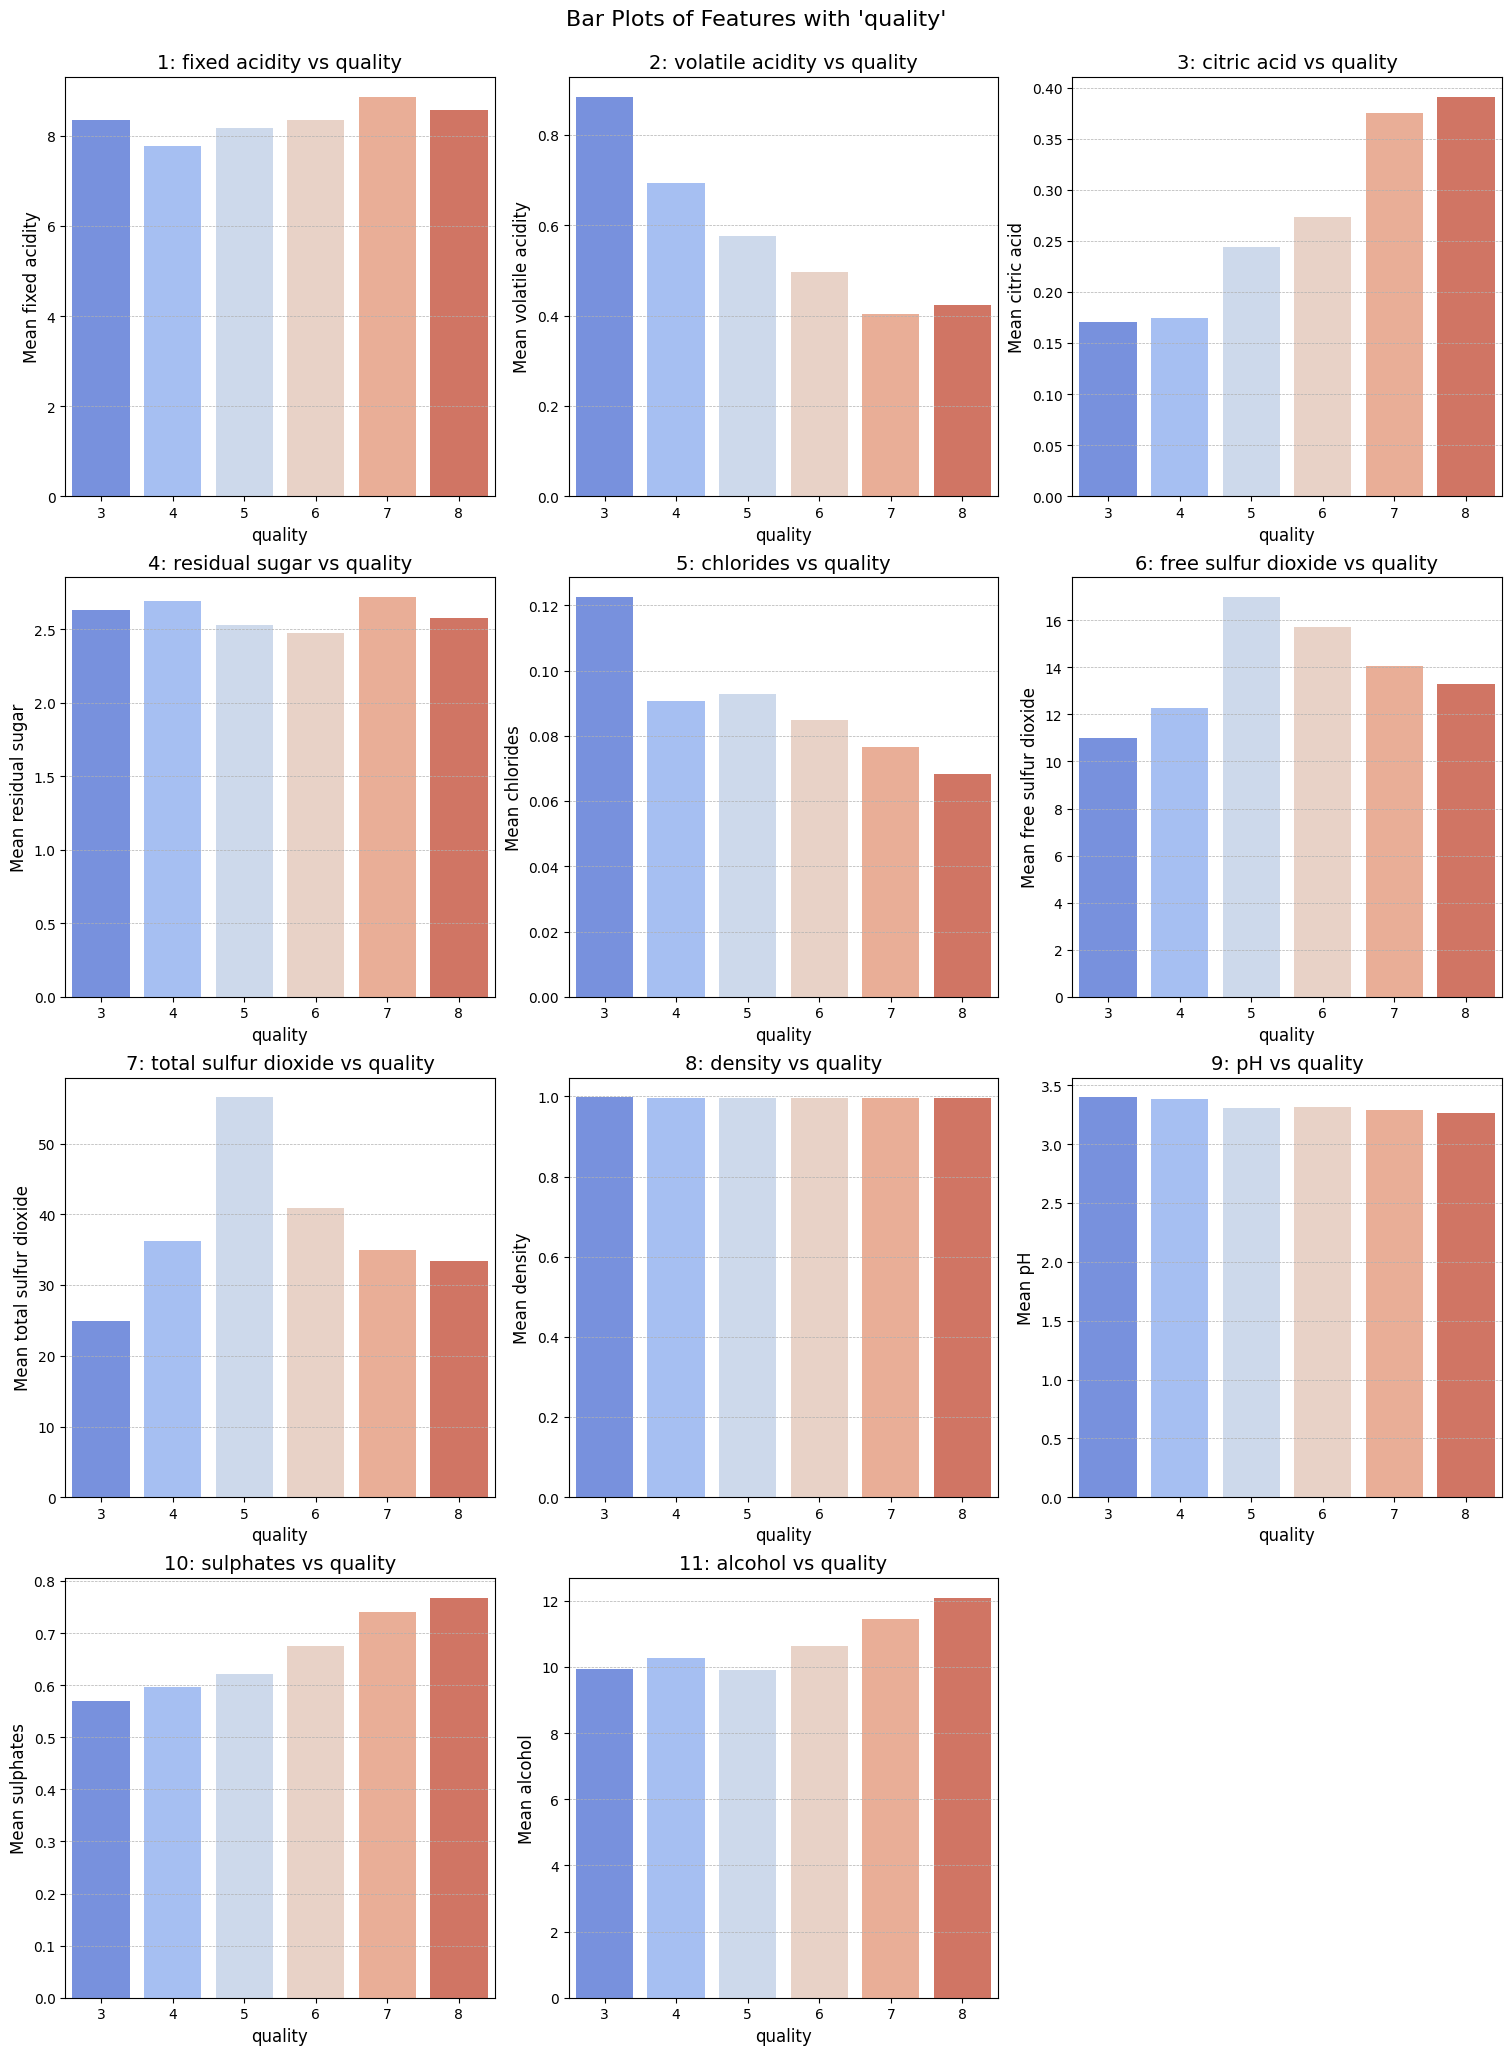

In [9]:
features = [col for col in dfr.columns if col != target]
num_features = len(features)
cols = 3
rows = (num_features + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    feature_means = dfr.groupby(target)[feature].mean().reset_index()
    sns.barplot(data=feature_means, x=target, y=feature, ax=ax, palette='coolwarm')
    ax.set_title(f"{i+1}: {feature} vs {target}", fontsize=14)
    ax.set_xlabel(target, fontsize=12)
    ax.set_ylabel(f"Mean {feature}", fontsize=12)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle(f"Bar Plots of Features with '{target}'", fontsize=16, y=1.02)
plt.show()


# Insights for Each Plot

### 1. Fixed Acidity vs Quality
- Fixed acidity shows no clear trend as wine quality increases.
- Wines with all quality levels have similar average fixed acidity values, suggesting it may not strongly influence quality.

### 2. Volatile Acidity vs Quality
- There is a clear negative correlation between volatile acidity and wine quality.
- Lower volatile acidity is associated with higher-quality wines.

### 3. Citric Acid vs Quality
- Citric acid levels tend to increase as wine quality improves.
- Higher-quality wines have higher citric acid content, suggesting it may positively influence quality.

### 4. Residual Sugar vs Quality
- Residual sugar shows little variation across quality levels.
- This feature likely does not significantly impact wine quality.

### 5. Chlorides vs Quality
- Chloride levels show a slight negative trend as quality improves.
- Lower chlorides may be slightly associated with better-quality wines.

### 6. Free Sulfur Dioxide vs Quality
- Free sulfur dioxide shows minimal variation across quality levels.
- It likely has a weak or negligible effect on wine quality.

### 7. Total Sulfur Dioxide vs Quality
- Higher levels of total sulfur dioxide are associated with lower-quality wines.
- A decrease in total sulfur dioxide may positively influence wine quality.

### 8. Density vs Quality
- Density does not vary significantly with quality, remaining fairly constant across all levels.
- It may not be a strong predictor of wine quality.

### 9. pH vs Quality
- The pH levels remain consistent across different wine quality levels.
- This indicates a limited relationship between pH and wine quality.

### 10. Sulphates vs Quality
- Sulphate levels increase as wine quality improves.
- Higher sulphates appear to be a positive indicator of better wine quality.

### 11. Alcohol vs Quality
- Alcohol content has a strong positive correlation with wine quality.
- Higher-quality wines generally have higher alcohol content.

---

# General Observations
- **Key Positive Indicators**: Alcohol, sulphates, and citric acid are associated with better wine quality.
- **Key Negative Indicators**: Volatile acidity is negatively correlated with wine quality.
- **Neutral Features**: Features like residual sugar, free sulfur dioxide, density, and pH show minimal influence on quality.
- **Wierd Features**:  Total sulfur dioxide has looks like it distrubtes like a normal distibution for quality, where the averages wine have the most total sulfar dioxide

---
#### The next logical step will be to visulize the Positive and Negative indicators on higher end wines and lower end wines. For that task a spider plot will be perfect, the problem is that not all our features are in the same range. To solve that, we will use the min max scaler.

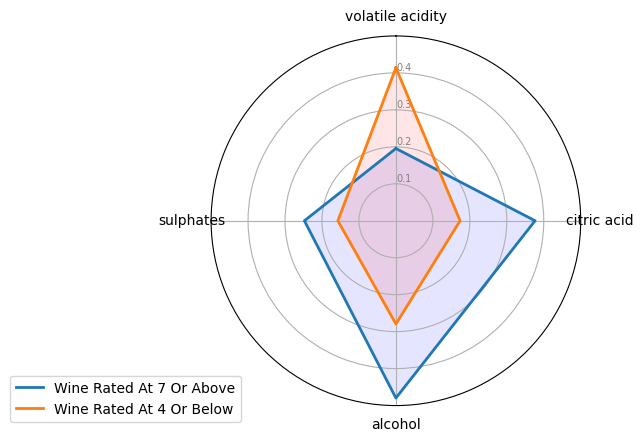

In [10]:
scaler = MinMaxScaler()
standardized_dfr = pd.DataFrame(scaler.fit_transform(dfr),columns=dfr.columns)
dfr_best = standardized_dfr[dfr.quality>=7]
dfr_worst = standardized_dfr[dfr.quality<=4]
categories = ['volatile acidity', 'citric acid', 'alcohol', 'sulphates']
N=len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
ax = plt.subplot(111, polar=True)
 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
ticks = [0.1,0.2,0.3,0.4]
plt.yticks(ticks, [str(num) for num in ticks], color="grey", size=7)
plt.ylim(0,0.5)
 

values=dfr_best[categories].mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Wine Rated At 7 Or Above")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=dfr_worst[categories].mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Wine Rated At 4 Or Below")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

### Insights from the Spider Plot

1. **Higher Sulphates**:
   - Wines rated 7 or above have significantly higher sulphate levels. Sulphates act as a preservative, enhancing the wine's longevity and stability, which contributes to its higher quality.

2. **Increased Alcohol Content**:
   - Premium wines (rated 7 or above) consistently feature higher alcohol levels. Alcohol enhances the wine's body, warmth, and sensory experience, making it more appealing.

3. **More Citric Acid**:
   - High-quality wines show elevated citric acid content, which contributes to a fresher and more vibrant flavor profile, enhancing the overall drinking experience.

4. **Lower Volatile Acidity**:
   - The best wines have reduced volatile acidity, resulting in a smoother and more balanced flavor without the sharpness that excessive acidity can bring.


Overall, wines with better ratings are not just about one aspect but a combination of factors—preservation, flavor, and balance—working together to elevate quality.


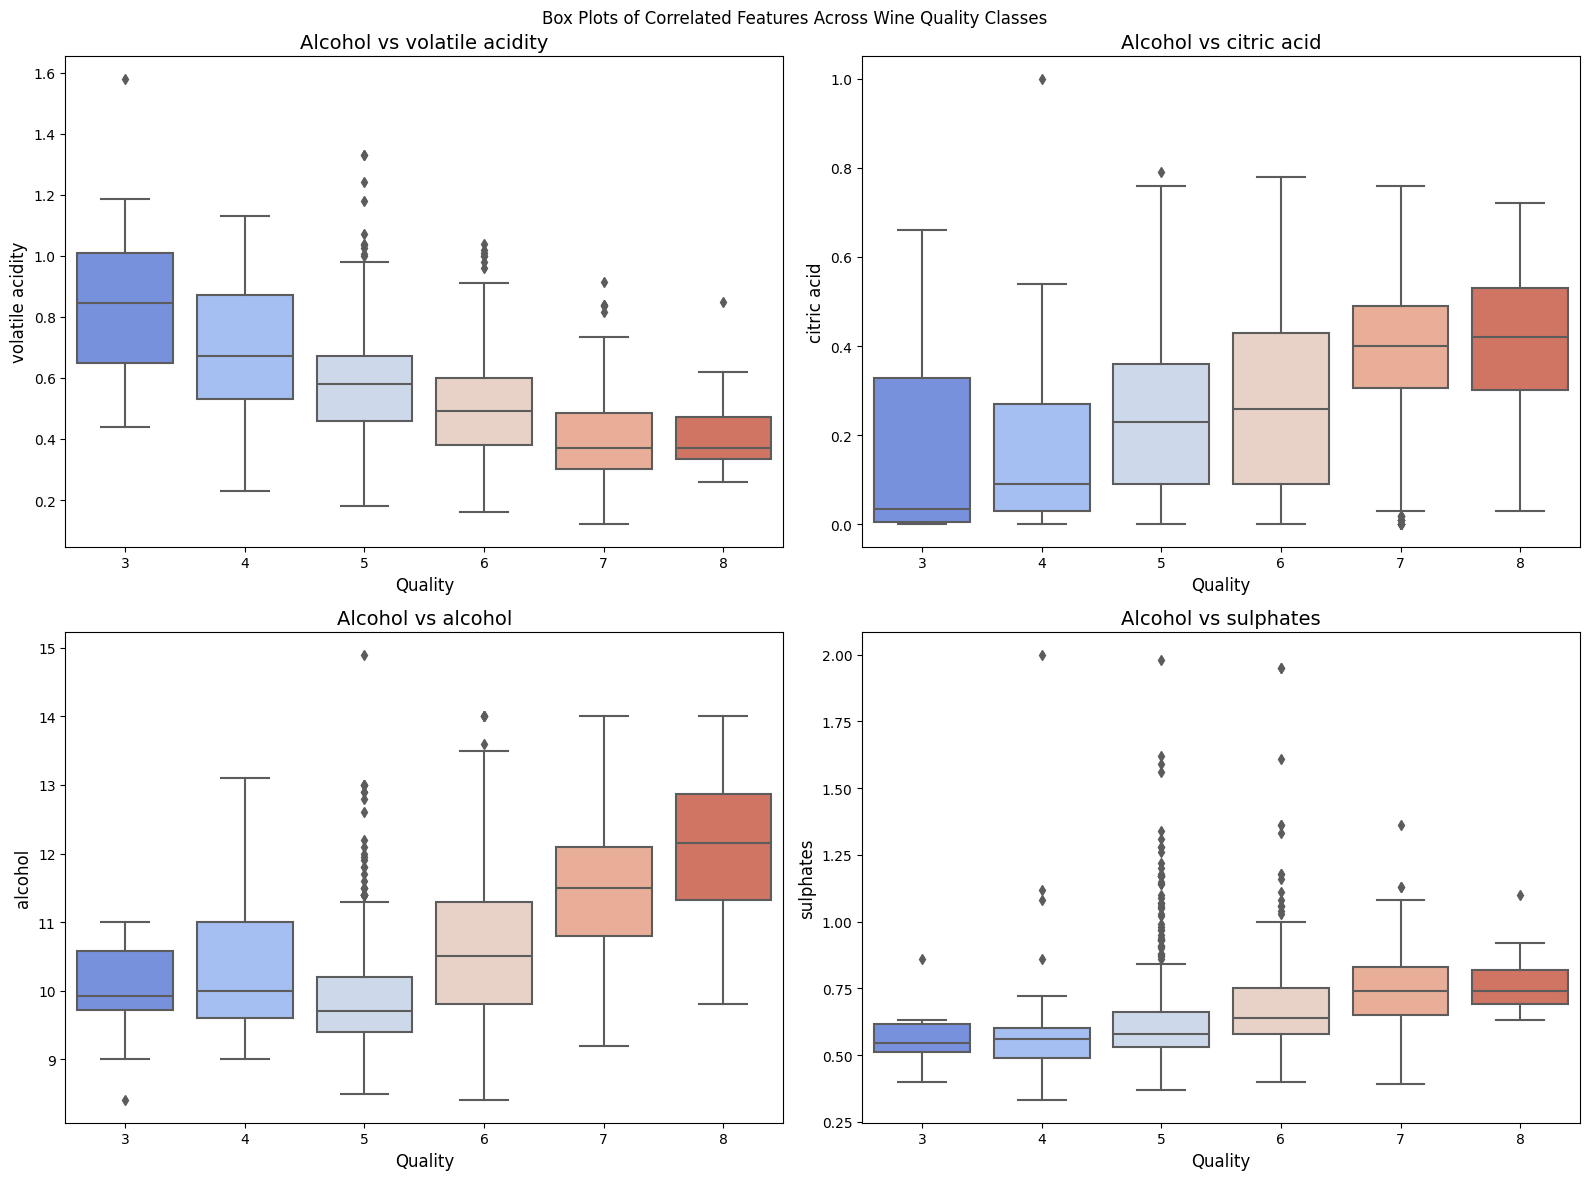

In [11]:
corelated_features = ['volatile acidity', 'citric acid', 'alcohol' ,'sulphates']

# Create a figure with a subplot for each corelated feature
fig, axes = plt.subplots(len(corelated_features)//2, 2, figsize=(16, 12))
fig.suptitle('Box Plots of Correlated Features Across Wine Quality Classes')

# Box plot for the first correlated feature (e.g., alcohol vs quality)

for idx, feature in enumerate(corelated_features):
    sns.boxplot(x=target, y=feature, hue=target, data=dfr, ax=axes[idx // 2, idx % 2], palette="coolwarm", dodge=False)
    axes[idx // 2, idx % 2].set_title(f"Alcohol vs {feature}", fontsize=14)
    axes[idx // 2, idx % 2].set_xlabel("Quality", fontsize=12)
    axes[idx // 2, idx % 2].set_ylabel(feature, fontsize=12)
    axes[idx // 2, idx % 2].legend_.remove()  # Remove the legend for cleaner visualization

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

to do: examine what informatino about the data can I get out of this

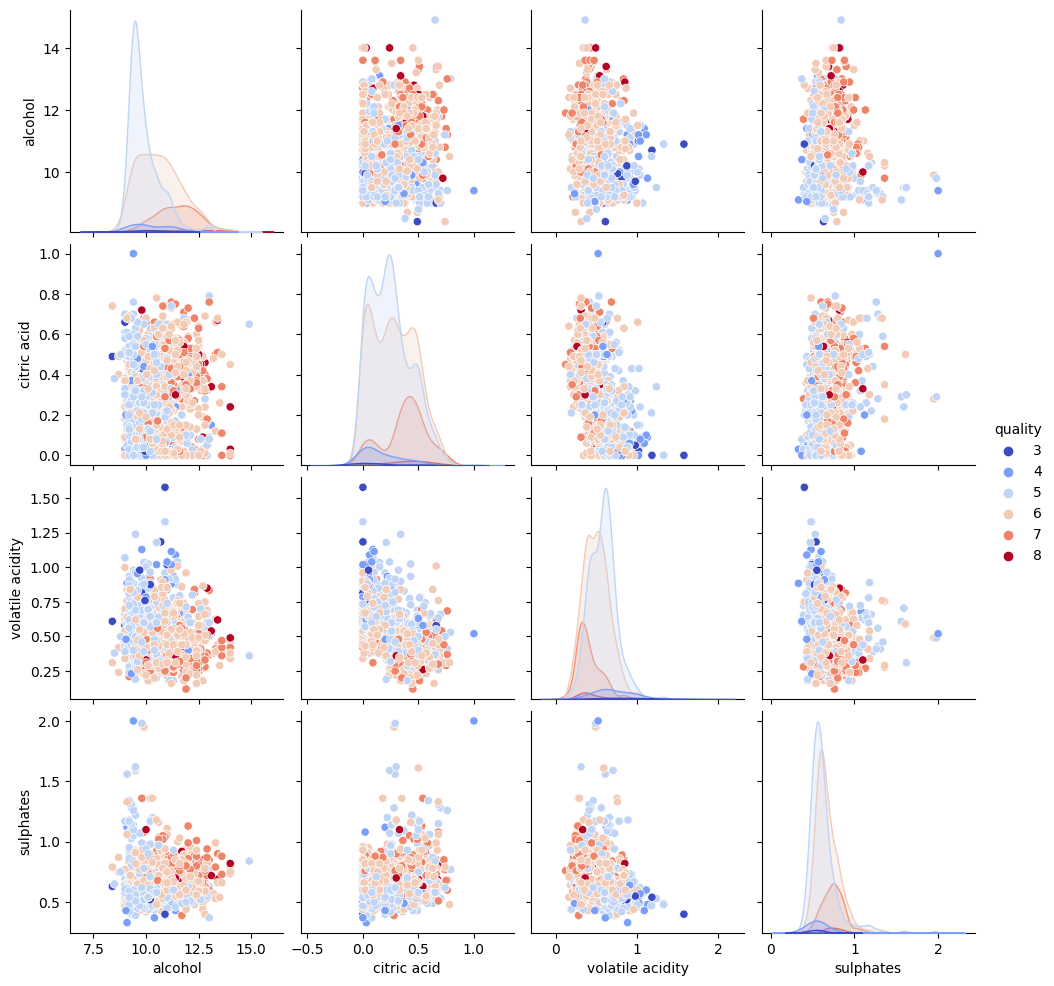

In [12]:
sns.pairplot(dfr[['quality', 'alcohol', 'citric acid', 'volatile acidity', 'sulphates']], hue='quality', palette="coolwarm")
plt.show()

# TODO: the following is a good check for outlier:
# TODO: in the bar plots the ph and density are not good plots, need standardization

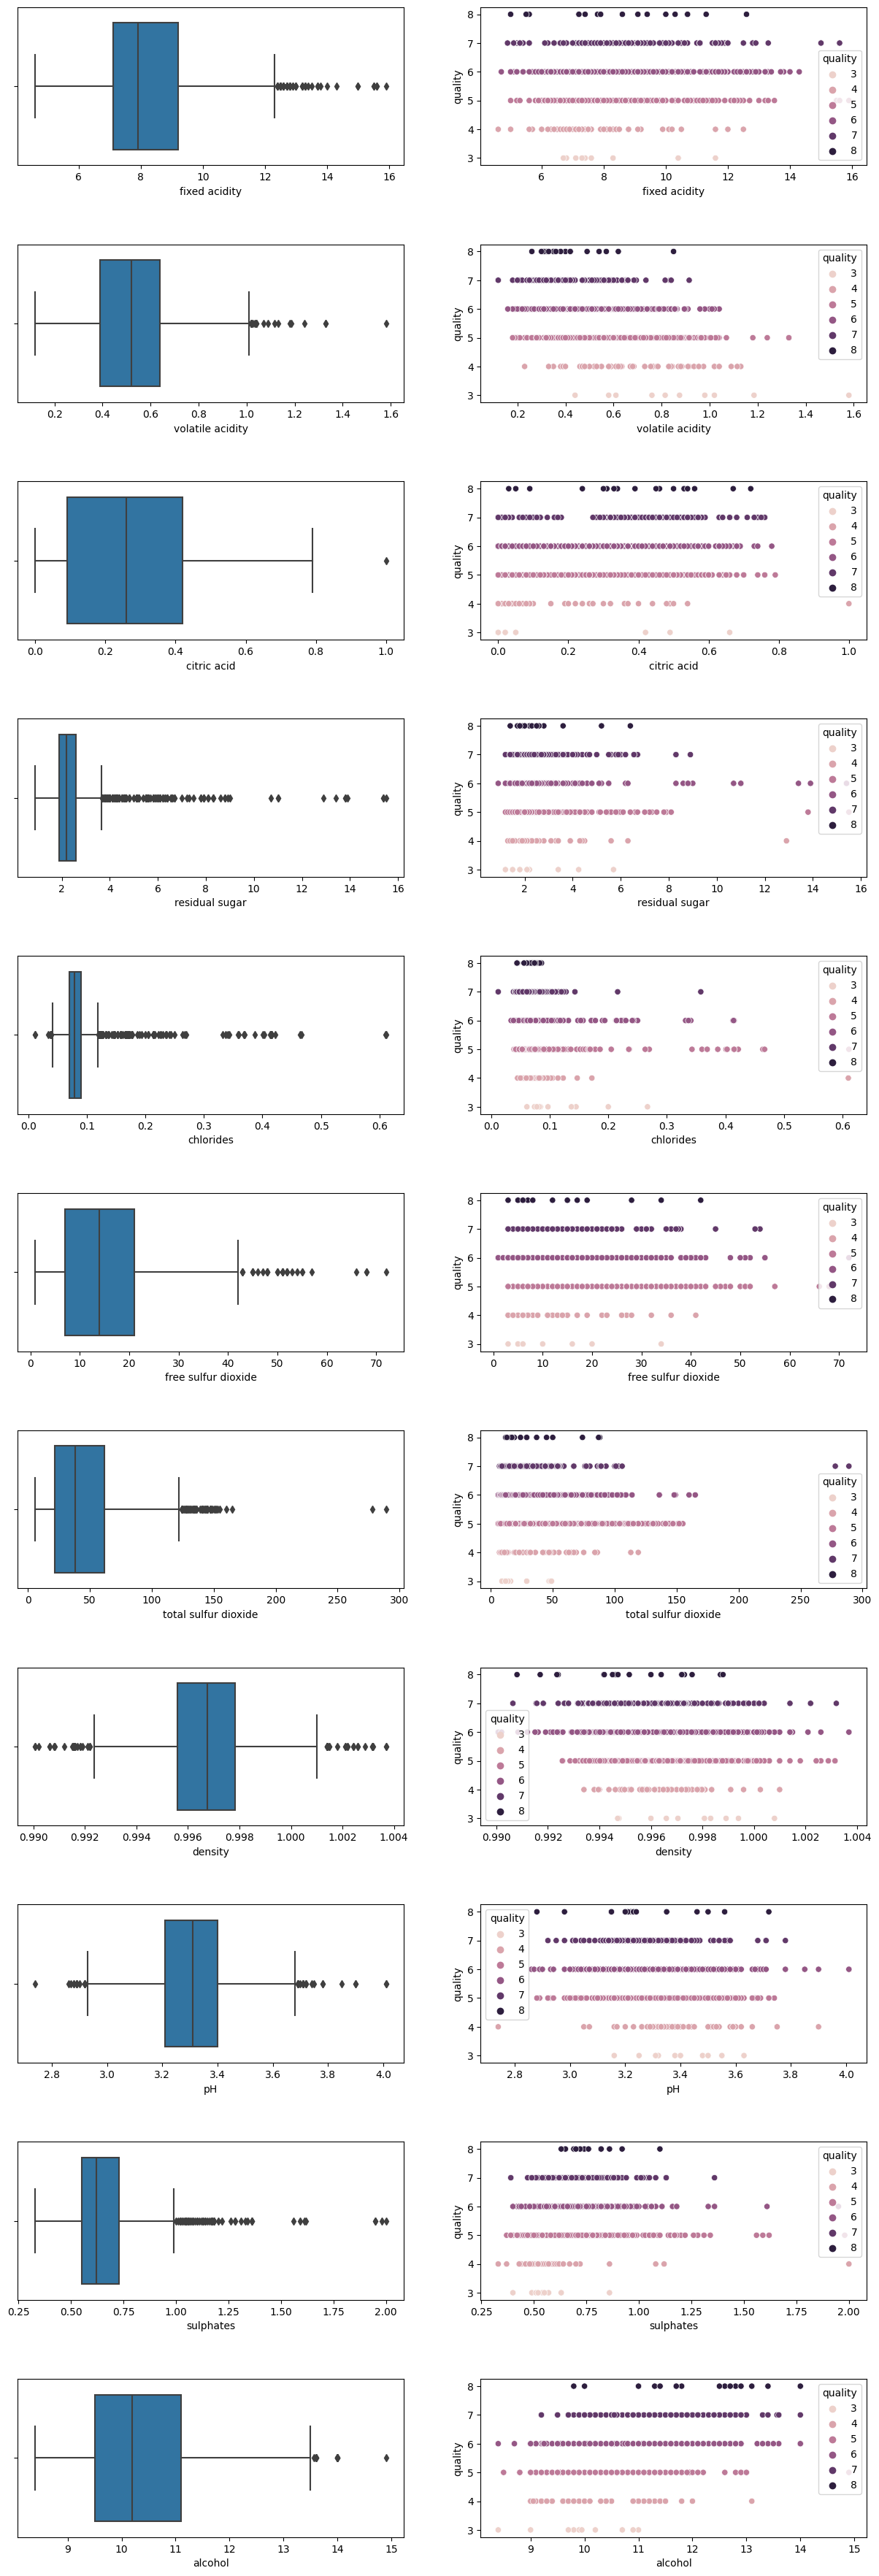

In [15]:
fig, ax = plt.subplots(11, 2, figsize=(15, 45))
plt.subplots_adjust(hspace = 0.5)
for i in range(11) :
    sns.boxplot(x=dfr.columns[i], data=dfr, ax=ax[i, 0])
    sns.scatterplot(x=dfr.columns[i], y='quality', data=dfr, hue='quality', ax=ax[i, 1])

---

# Basic Model Pipeline

In [23]:
X = dfr.drop(columns=[target])
y = dfr[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')


Mean Absolute Error: 0.44622124433517457


# TODO: add confusion matrix and classification report, check which wines the model performs the worst, check which features doesnt help the model, check more model.